# Assignment 1c Notebook: Multi-Objective EA
This notebook is part of Assignment 1c, which will guide you through half of this two-part assignment: building a multi-objective EA (MOEA). This assignment builds on the EA code you wrote in Assignment 1b; therefore, if this is the first notebook you're filling out for Assignment 1c, you should copy over the following files:
* 1a_notebook.ipynb
* 1b_notebook.ipynb
* base_evolution.py
* bridge_population_evaluation.py
* linear_genotype.py
* selection.py


*Be careful* to not copy over functions relating to the provided fitness functions or bridge structures (files you shouldn't have modified anyways). We may have changed those and we want you to have the versions that were provided with this repo.

As usual, be sure to **read all of this notebook** and you can start by executing the next cell.

In [23]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

print('The first cell has been executed!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The first cell has been executed!


## Multi-Objective Fitness Evaluations
In a traditional MOEA implementation like the Non-dominated Sorting Genetic Algorithm II [(NSGA-II)](https://ieeexplore.ieee.org/abstract/document/996017?casa_token=sIy9DHU74qAAAAAA:f9M0Nu6WrHIswdRILFlqhxUqW-rK1nfke65Xw88A1JNX5TaaXZAL76yrC3L8WncdUlrDi25Y7Zo), individuals in a population are assessed by multiple objectives, assigned a score for each objective, and are then sorted into levels of non-domination (more on that later) during parent and survival selection. In a traditional MOEA implementation, you might write a multi-objective version of k-tournament that samples k individuals from the population and selects the winner as the individual who is on the Pareto front from those k individuals. This formulation thus doesn't use a single-value notion of fitness as your existing k-tournament implementations do. This works because k-tournament selection is a rank-based algorithm, only relying on relative comparisons between individuals (more fit, less fit, or equally-fit). However, not all selection algorithms work this way: for example, fitness-proportional selection requires numeric values that are proportional to fitness.

To enable the re-use of your existing selection algorithms, we propose a novel MOEA implementation that assigns individuals in a population a singular fitness value based on their level of non-domination. This behaves in a functionally equivalent manner to the rank-based selection algorithms used in traditional MOEA implementations.

In your MOEA for this assignment, you will do the following:
* Evaluate new members in a population to assign objective scores
* Construct a domination table for *all* individuals in the population
* Sort the population into levels of non-domination where level 0 is the Pareto front
* To each individual in the population, assign a representative fitness that is inversely proportional to their level of non-domination 
 - i.e., `num_levels - my_level`

To accomplish this, you'll implement three functions:
1. `multi_objective_population_evaluation` - which assigns objective score to new population members after initialization
2. `dominates` - which takes individuals `A` and `B` as  inputs and returns `True` if `A` dominates `B`
3. `non_domination_sort` - which sorts the population into levels of non-domination and assigns a representative fitness.

First, let's start by showing an example of the new fitness function `multi_objective_simulation`. This behaves the same as `basic_simulation`, except the first returned value is a list of fitness values (one for each objective).

The solution's objective scores are:
-98,000,000.0
-309.6341467212142


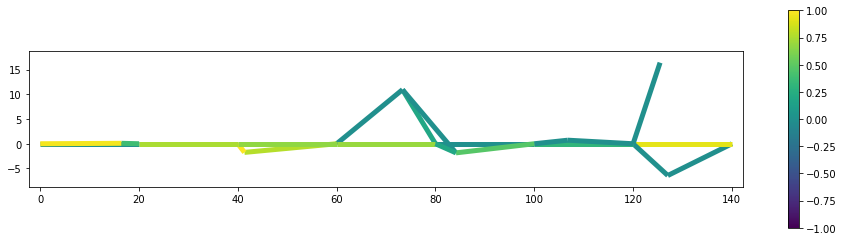

In [24]:
from selection import *
from snake_eyes import read_config
from linear_genotype import LinearGenotype
from bridge_fitness import multi_objective_simulation, plot_bridge

config = read_config('./configs/green1c1_config.txt', globalVars=globals(), localVars=locals())

test_solution = LinearGenotype()
test_solution.random_initialization(**config['initialization_kwargs'])

test_solution.objectives, test_solution.bridge = multi_objective_simulation(test_solution.gene, **config['fitness_kwargs'])

print(f"The solution's objective scores are:")
for objective in test_solution.objectives:
    print(f"{objective:,}")
plot_bridge(test_solution.bridge)

del config, test_solution # to prevent haphazard copypasta

### Objectives
For the green and yellow deliverables in this assignment, the objectives considered are as follows:
 1.  Weight - The amount of weight a bridge can support before failing or a negative value if the bridge cannot support its own weight (the standard definition of fitness we've been using throughout this assignment series).
 2.  Material - The negated total length of material used to construct the bridge. This metric reflects the cost in materials to build the bridge, though we negate this value so you can consistently consider the higher value as better across all your objectives.

For one of the red (bonus) deliverables, you'll also consider a third objective:

 3.  Height - Highest y-value in the connected bridge. (See assignment description document for more info.)

Now that you've seen an example of calling the fitness function in a new way, complete the `multi_objective_population_evaluation` function in `bridge_population_evaluation.py`, which takes as input a population and fitness_kwargs dictionary and populates the `objectives` and `bridge` member variables of all individuals in the population. It should look fairly similar to your `basic_population_evaluation` function, but it will call `multi_objective_simulation` and will not assign to the fitness member.

In [34]:
import statistics
from bridge_population_evaluation import multi_objective_population_evaluation

config = read_config('./configs/green1c1_config.txt', globalVars=globals(), localVars=locals())

example_population = LinearGenotype.initialization(10, **config['initialization_kwargs'])
# Note explicitly initializing to None is unnecessary in general
# We only do it here to test that you've actually set these values
for individual in example_population:
    individual.objectives = None

# calling your function to test things out
multi_objective_population_evaluation(example_population, **config['fitness_kwargs'])
unassigned = len([individual.objectives for individual in example_population if individual.objectives is None])
print(f'Individuals with unassigned objectives: {unassigned}')
if unassigned == 0:
    weights = [individual.objectives[0] for individual in example_population]
    print(f'Best weight value: {max(weights):,}')
    print(f'Average weight value: {statistics.mean(weights):,}')
    materials = [individual.objectives[1] for individual in example_population]
    print(f'Best material value: {max(materials):,}')
    print(f'Average material value: {statistics.mean(materials):,}')

del config, example_population, unassigned

Individuals with unassigned objectives: 0
Best weight value: -93,000,000.0
Average weight value: -97,600,000.0
Best material value: -254.62947314198465
Average material value: -433.7802128903591


## Multi-Objective Domination
As discussed in the course lectures, a prevalent way to assess solutions in an MOEA is to determine whether or not a solution *dominates* another solution in the population. Recall from the lecture that an individual `A` is said to dominate an individual `B` if and only if:
* `A` is no worse than `B` in all objectives *AND*
* `A` is strictly better than `B` in at least one objective

In `domination.py`, implement the function `dominates` that compares the `objectives` member variables of the input individuals returns `True` if `A` dominates `B` and `False` otherwise.

To evaluate your implementation of the `dominates` function, we're going to compare against the model answer from Question 11 of the second exam from Fall 2020 [(link here)](http://bonsai.auburn.edu/dtauritz/courses/ec/intro/2020fall/IntroECfs2020exam2key.pdf). The output generated by executing the following cell should match the domination table from part (a) of that problem.

In [47]:
from domination import dominates

objective_scores = [[8,2],
                   [4,1],
                   [2,3],
                   [1,2],
                   [9,1],
                   [4,7],
                   [2,5],
                   [1,3],
                   [10,7],
                   [5,5]]
expectation = [[2, 4],
              [],
              [4,8],
              [],
              [2],
              [2,3,4,7,8],
              [3,4,8],
              [4],
              [1,2,3,4,5,6,7,8,10],
              [2,3,4,7,8]]

config = read_config('./configs/green1c1_config.txt', globalVars=globals(), localVars=locals())

example_population = LinearGenotype.initialization(len(objective_scores), **config['initialization_kwargs'])

# assigning objectives this way for demo purposes only
for index in range(len(objective_scores)):
    example_population[index].objectives = objective_scores[index]

print('ID\t Dominates')

# Note that this implementation of a domination table has some quirks so it matches the exam.
# Advise caution if you copy this code later because you should probably modify it.
for index in range(len(example_population)):
    domination_list = list()
    for opponent_index in range(len(example_population)):
        if index == opponent_index:
            continue
        if dominates(example_population[index], example_population[opponent_index]):
            domination_list.append(opponent_index+1)
    print(f'{index+1}\t{domination_list}', end='')
    if domination_list != expectation[index]:
        print(f'\texpected {expectation[index]}')
    else:
        print()
        
del config, example_population, expectation

ID	 Dominates
1	[2, 4]
2	[]
3	[4, 8]
4	[]
5	[2]
6	[2, 3, 4, 7, 8]
7	[3, 4, 8]
8	[4]
9	[1, 2, 3, 4, 5, 6, 7, 8, 10]
10	[2, 3, 4, 7, 8]


## Non-domination Sort
With the `dominates` function implemented, you can now implement the `non_domination_sort` function (which is also in `domination.py`). This function takes as input a population and has three main steps:
1. Calculate a domination lookup table (this is technically optional but provides a drastic speedup)
2. Sort individuals into levels of non-domination with the algorithm performed in class and where level 0 is the Pareto front
3. Assign each individual a representative fitness to their `fitness` member variable equal to the negation of its level of non-domination

Note: you may implement additional helper functions to call within `non-domination_sort` so long as calling the `non_domination_sort` function produces the expected results.

We'll evaluate your `non_domination_sort` implementation using the same exam question we used to evaluate `dominates`. As such, your algorithm should generate `fitness` values that describe a non-domination sort with a similar result to that in the model answer.

In [48]:
from domination import non_domination_sort

config = read_config('./configs/green1c1_config.txt', globalVars=globals(), localVars=locals())

example_population = LinearGenotype.initialization(len(objective_scores), **config['initialization_kwargs'])

# assigning objectives this way for demo purposes only
for index in range(len(objective_scores)):
    example_population[index].objectives = objective_scores[index]

# calling your function to test it out
pf = non_domination_sort(example_population)
unassigned = len([individual.fitness for individual in example_population if individual.fitness is None])
print(f'Individuals with unassigned fitness: {unassigned}')
evaluations = len([individual.fitness for individual in example_population if individual.fitness is not None])
print(f'Number of fitness evaluations performed: {evaluations}')

fitnesses = set()

for individual in example_population:
    if individual.fitness is not None:
        # truncate the fitness values in case you've implemented the YELLOW deliverable
        individual.fitness = int(individual.fitness)
    fitnesses.add(individual.fitness)

fitnesses = sorted(list(fitnesses), reverse=True)


print('\nLevels of non-domination after adding all elements')
for level_index in range(len(fitnesses)):
    level = sorted([i+1 for i in range(len(example_population)) if example_population[i].fitness == fitnesses[level_index]])
    print(f'level {level_index}: {level}')

del config, example_population, unassigned, evaluations, fitnesses, objective_scores, level

Individuals with unassigned fitness: 0
Number of fitness evaluations performed: 10

Levels of non-domination after adding all elements
level 0: [9]
level 1: [1, 5, 6, 10]
level 2: [7]
level 3: [3]
level 4: [2, 8]
level 5: [4]


## Assembling the MOEA
Now that you have `multi_objective_population_evaluation`, `dominates`, and `non_domination_sort` functions implemented, you can assemble your complete MOEA using the `BaseEvolutionPopulation` population class you implemented in Assignment 1b. There are, however, some small differences from a single-objective EA that we'll walk you through in the following example.

In [49]:
from base_evolution import BaseEvolutionPopulation

config = read_config('./configs/green1c1_config.txt', globalVars=globals(), localVars=locals())

# full initialization of your EA
exampleEA = BaseEvolutionPopulation(**config['EA_configs'], **config)
multi_objective_population_evaluation(exampleEA.population, **config['fitness_kwargs'])

# count evaluations for initial population
exampleEA.evaluations = len(exampleEA.population)
print(f'Number of fitness evaluations: {exampleEA.evaluations}')

Number of fitness evaluations: 100


Until this point, the EA has gone as expected. We've read a config, initialized the EA, and evaluated the initial population. Recall, however, that the fitness evaluation only assigns objective scores that can't directly be used as single-value fitness in evolution. To calculate a single fitness value and evolve as usual, we have to add a call to the new `non_domination_sort` before entering child generation (and parent selection).

In [50]:
# sort population and assign representative fitness
pf = non_domination_sort(exampleEA.population)
for individual in pf:
    print(individual.crowdingDistance)
    #    print(individual.objectives[0], individual.objectives[1])
#print('Individuals in Pareto front')
#print(pf)

0
0
0


Once `non_domination_sort` has been called, the EA can generate children. Once the children are evaluated for objective scores and have been added to the population, we need to re-sort the population and re-calculate representative fitness before entering survival selection. As a rule of thumb, you'll need to re-calculate representative fitness using `non_domination_sort` before each function call that utilizes a selection algorithm.

In [51]:
# generate children
children = exampleEA.generate_children()
multi_objective_population_evaluation(children, **config['fitness_kwargs'])
exampleEA.evaluations += len(children)
print(f'Number of fitness evaluations: {exampleEA.evaluations}')

# re-sort modified population and assign representative fitness
non_domination_sort(exampleEA.population)

# perform survival selection
exampleEA.survival()

del exampleEA, children # to prevent haphazard copypasta

Number of fitness evaluations: 110


The calls to `non_domination_sort` are new additions to the EA cycle, but otherwise the MOEA cycle closely resembles that of previous assignments.

Now that you've implemented the necessary functions and the MOEA cycle has been demonstrated, implement a single run of your MOEA that searches for 5,000 fitness evaluations.

In [92]:
from math import inf

def multi_objective_EA_search(run_number, number_evaluations, config_filename, crowding=False):
    # Parse the config and implement your EA here.
    # Feel free to focus on implementation first and then return for data collection.
    
    evalNum = 0
    overallBestWeight = -inf
    overallBestMaterial = -inf
    paretoFront = None
    bestWeights = []
    aveWeights = []
    bestMaterials = []
    aveMaterials = []
    
    config = read_config(config_filename, globalVars=globals(), localVars=locals())
    
    # initialization
    evoAlgo = BaseEvolutionPopulation(**config['EA_configs'], **config)
    multi_objective_population_evaluation(evoAlgo.population, **config['fitness_kwargs'])
    # count evaluations for initial population
    evoAlgo.evaluations = len(evoAlgo.population)
    # sort population and assign representative fitness
    paretoFront = non_domination_sort(evoAlgo.population, yellow=crowding)
    
    weights = [individual.objectives[0] for individual in evoAlgo.population]
    materials = [individual.objectives[1] for individual in evoAlgo.population]
    
    if not crowding:
        filepath = 'data/1c_notebook1/green/run' + str(run_number) + '/'
    else:
        filepath = 'data/1c_notebook1/yellow/run' + str(run_number) + '/'
    
    with open(filepath + 'gens.txt', 'w') as fp:
        fp.write('Initialization\n')
        fp.write(f'Number of fitness evaluations: {evoAlgo.evaluations}\n')
        fp.write(f'Best weight value: {max(weights):,} \t Best material value: {max(materials):,}\n')
        fp.write(f'Average weight value: {statistics.mean(weights):,} \t Average material value: {statistics.mean(materials):,}\n')
        fp.write('-----------------------\n')
        
    bestWeights.append(max(weights))
    aveWeights.append(statistics.mean(weights))
    bestMaterials.append(max(materials))
    aveMaterials.append(statistics.mean(materials))
    
    while not(evalNum == number_evaluations):
        # generate children
        children = evoAlgo.generate_children()
        multi_objective_population_evaluation(children, **config['fitness_kwargs'])
        evoAlgo.evaluations += len(children)
        #print(f'Number of fitness evaluations: {evoAlgo.evaluations}')
        
        # (𝜇 + 𝜆)
        evoAlgo.population += children

        # re-sort modified population and assign representative fitness
        paretoFront = non_domination_sort(evoAlgo.population, yellow=crowding)

        # perform survival selection
        evoAlgo.survival()
        
        # re-sort modified population and assign representative fitness
        paretoFront = non_domination_sort(evoAlgo.population, yellow=crowding)
        
        weights = [individual.objectives[0] for individual in evoAlgo.population]
        materials = [individual.objectives[1] for individual in evoAlgo.population]
        
        with open(filepath + 'gens.txt', 'a') as fp:
            fp.write(f'Generation #: {evalNum}\n')
            fp.write(f'Number of fitness evaluations: {evoAlgo.evaluations}\n')
            fp.write(f'Best weight value: {max(weights):,} \t Best material value: {max(materials):,}\n')
            fp.write(f'Average weight value: {statistics.mean(weights):,} \t Average material value: {statistics.mean(materials):,}\n')
            fp.write('-----------------------\n') 
            
        bestWeights.append(max(weights))
        aveWeights.append(statistics.mean(weights))
        bestMaterials.append(max(materials))
        aveMaterials.append(statistics.mean(materials))
        
        if(max(weights) > overallBestWeight):
            overallBestWeight = max(weights)
        
        if(max(materials) > overallBestMaterial):
            overallBestMaterial = max(materials)
            
        evalNum += 1
    
            
    return overallBestWeight, overallBestMaterial, aveMaterials, aveWeights, paretoFront
            

In [93]:
# calling your function
print(multi_objective_EA_search(0, 5000, './configs/green1c1_config.txt', crowding=True))

(-87000000.0, -147.78235144555757, [-476.9319853986695, -473.7744293323764, -453.70454815781113, -425.89029190560615, -434.5377333605381, -425.442906323894, -425.44284490667354, -435.8775710684854, -437.95814384541796, -435.8775994401377, -440.7448357323039, -440.7448357323039, -419.40281200450966, -419.40280124852364, -419.402781387085, -430.8347081576203, -430.83474558504287, -417.3322093302922, -395.6729272419515, -401.9982540713579, -380.23804308031816, -380.23806374530795, -388.6106127531332, -336.8205181467036, -299.50732902346124, -306.69446073627284, -306.6944461832933, -327.349635346228, -339.96994099674157, -343.97150847864964, -320.1306732592718, -296.2898831309552, -274.5296586582981, -274.30681820992885, -273.2016900299061, -273.2016990352229, -277.57452785621587, -302.60247664532767, -323.2576954134694, -343.9128987137676, -318.8849176564348, -314.8834338439957, -314.8834338439957, -298.2297809480752, -279.91171838458627, -296.56539982390086, -282.248835044976, -263.54795

Now that you've tested an implementation of a single run, implement code to perform 30 runs of your MOEA search that each contain 5,000 evaluations. For each generation of each run, log the mean and best values for all objectives in the current population as well as the number of fitness evaluations performed so far (including the initial population). Also for each run, record the objective scores and bridges for all individuals in the Pareto front of the final generation. The bridges and objective scores will be used for analysis in your report.

If you have attempted the YELLOW deliverable, you should record the diversity of the Pareto front from the final population of each run using a diversity metric of your choice.

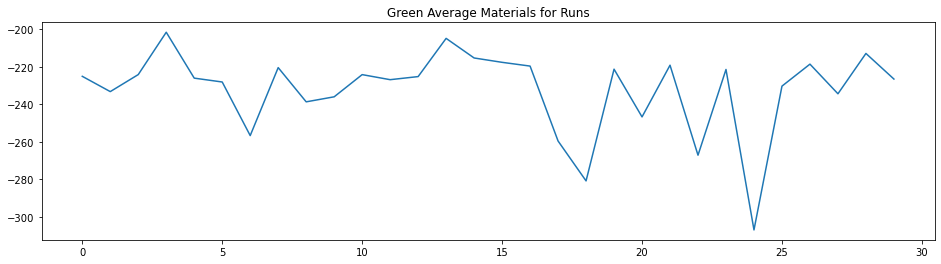

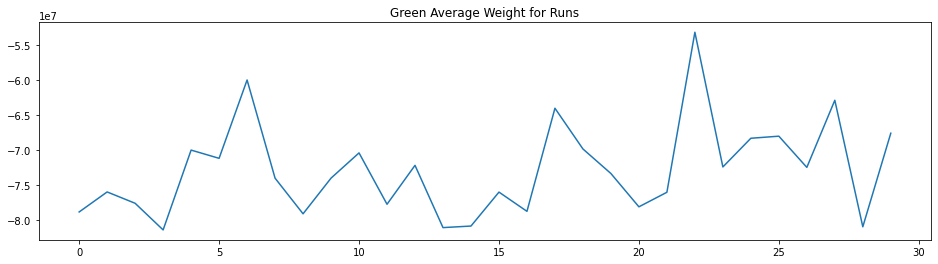

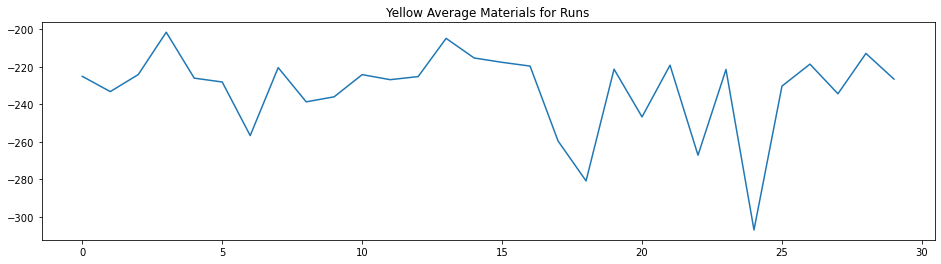

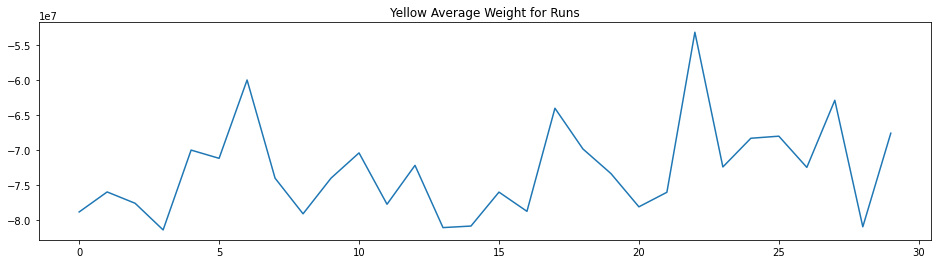

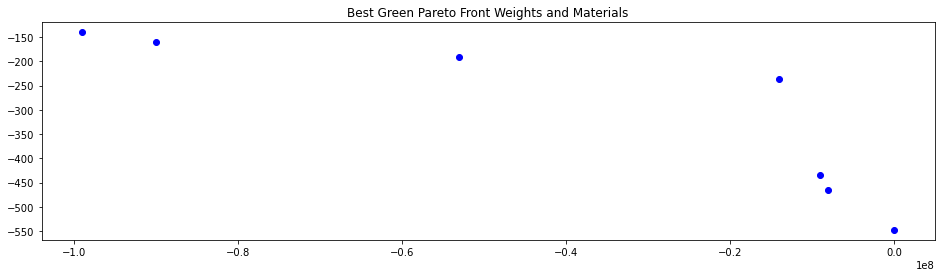

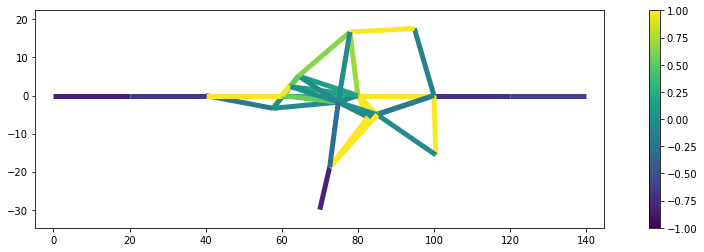

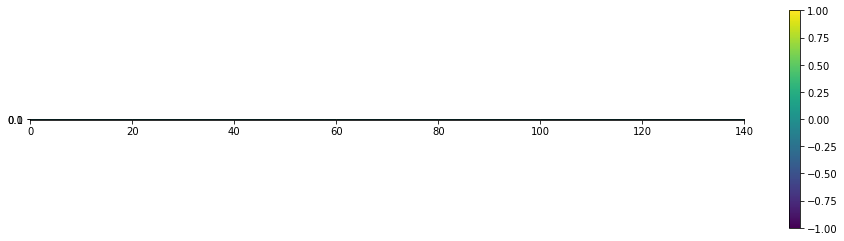

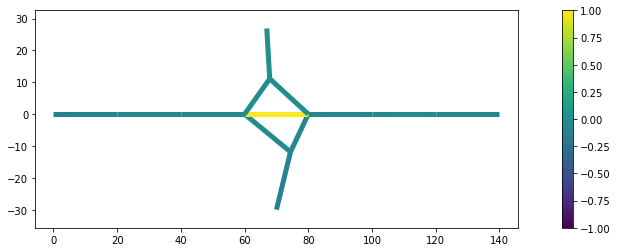

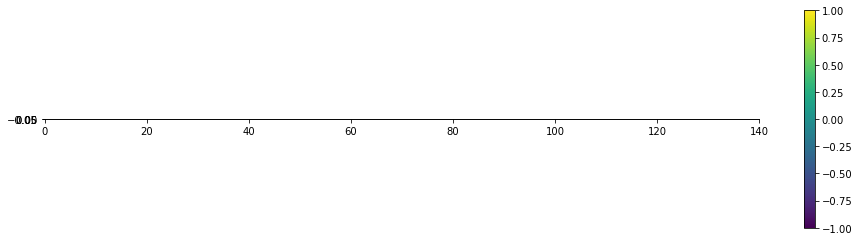

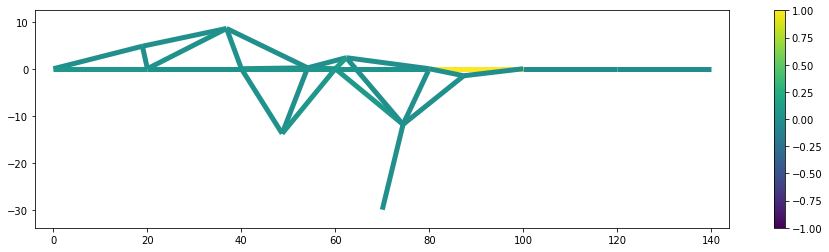

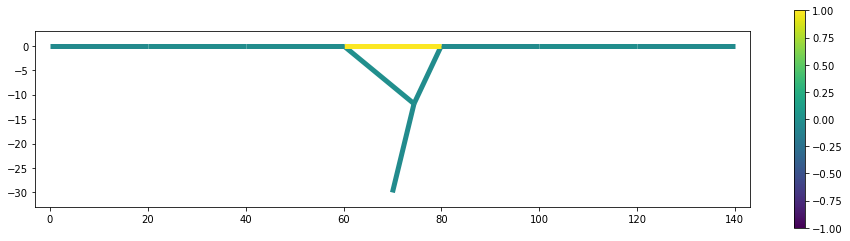

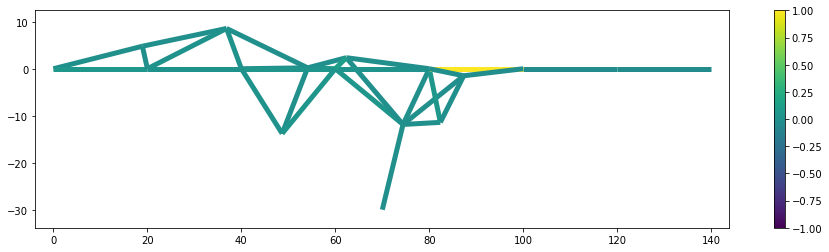

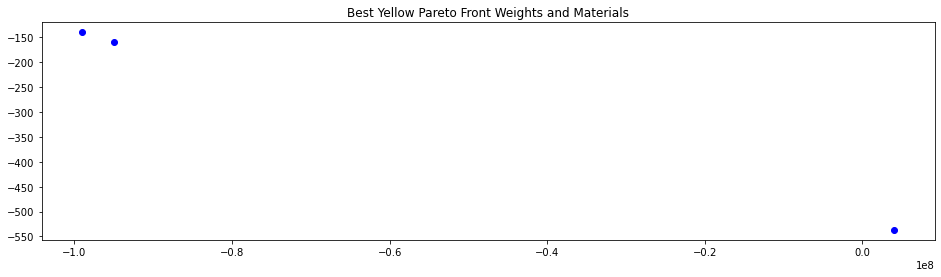

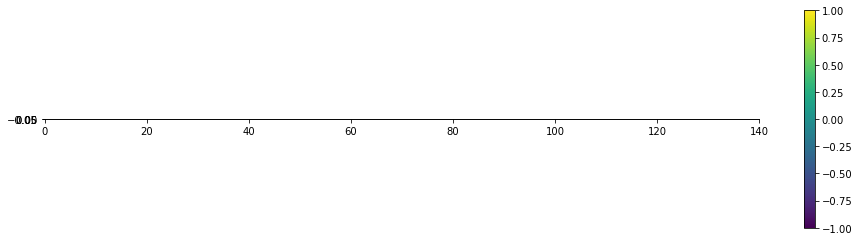

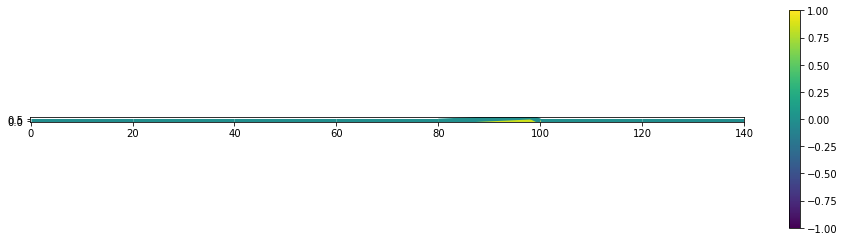

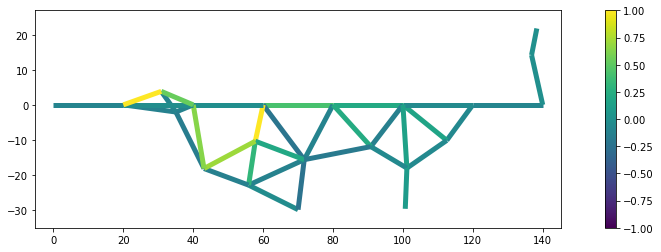

In [104]:
from domination import dominates

number_runs = 30
number_evaluations = 5000

greenParetoFronts = []
greenWeightAverages = []
greenMaterialAverages = []

yellowParetoFronts = []
yellowWeightAverages = []
yellowMaterialAverages = []

# You can parse different configuration files here as necessary
config = read_config('./configs/green1c1_config.txt', globalVars=globals(), localVars=locals())

# implement your multi-run experiment here

greenFilePath = 'data/1c_notebook1/green/'
yellowFilePath = 'data/1c_notebook1/yellow/'

fileOperaton = None

for count in range(number_runs):
    
    if count == 0:
        fileOperation = 'w'
    else:
        fileOperation = 'a'
    
    # green experiement
    bestWeight, bestMaterial, averageMaterials, averageWeights, paretoFront = multi_objective_EA_search(count, 5000, './configs/green1c1_config.txt', crowding=False)
    
    with open(greenFilePath + 'best.txt', fileOperation) as fp:
        fp.write(f'Weight: {bestWeight}, Material: {bestMaterial}\n')
        fp.write('----------------------\n')
        
    greenParetoFronts.append(paretoFront)
    
    # taking average of averages
    
    averageWeight = sum(averageWeights) / len(averageWeights)
    
    greenWeightAverages.append(averageWeight)
    
    averageMaterial = sum(averageMaterials) / len(averageMaterials)
    
    greenMaterialAverages.append(averageMaterial)
    
    
    # yellow experiement
    bestWeight, bestMaterial, averageMaterial, averageWeight, paretoFront = multi_objective_EA_search(count, 5000, './configs/green1c1_config.txt', crowding=True)

    with open(yellowFilePath + 'best.txt', fileOperation) as fp:
        fp.write(f'Weight: {bestWeight}, Material: {bestMaterial}\n')
        fp.write('----------------------\n')
        
    yellowParetoFronts.append(paretoFront)
    
    # taking average of averages
    
    averageWeight = sum(averageWeights) / len(averageWeights)
    
    yellowWeightAverages.append(averageWeight)
    
    averageMaterial = sum(averageMaterials) / len(averageMaterials)
    
    yellowMaterialAverages.append(averageMaterial)
    
    
plt.figure()
plt.title(f'Green Average Materials for Runs')
plt.plot(range(len(greenMaterialAverages)), greenMaterialAverages)
plt.savefig(greenFilePath + 'averageMaterialPlot.png')
    
plt.figure()
plt.title(f'Green Average Weight for Runs')
plt.plot(range(len(greenWeightAverages)), greenWeightAverages)
plt.savefig(greenFilePath + 'averageWeightPlot.png')
    
    
plt.figure()
plt.title(f'Yellow Average Materials for Runs')
plt.plot(range(len(yellowMaterialAverages)), yellowMaterialAverages)
plt.savefig(yellowFilePath + 'averageMaterialPlot.png')
    
plt.figure()
plt.title(f'Yellow Average Weight for Runs')
plt.plot(range(len(yellowWeightAverages)), yellowWeightAverages)
plt.savefig(yellowFilePath + 'averageWeightPlot.png')
    
# find the best pareto front for green
paretoDominateCountList = []
    
for count in range(len(greenParetoFronts)):
    dominateCount = 0
    for frontCount in range(len(greenParetoFronts[count])):
        for opFrontCount in range(len(greenParetoFronts[count])):
            if not frontCount == opFrontCount:
                if(dominates(greenParetoFronts[count][frontCount], greenParetoFronts[count][opFrontCount])):
                    dominateCount += 1
        
    paretoDominateCountList.append(dominateCount)
        
    
bestParetoFront = greenParetoFronts[paretoDominateCountList.index(max(paretoDominateCountList))]
    
# plotting pareto front
paretoFrontWeights = [individual.objectives[0] for individual in bestParetoFront]
paretoFrontMaterials = [individual.objectives[1] for individual in bestParetoFront]
    
plt.figure()
plt.title(f'Best Green Pareto Front Weights and Materials')
plt.plot(paretoFrontWeights, paretoFrontMaterials, 'bo')
plt.savefig(greenFilePath + 'bestGreenParetoFrontPlot.png')
    
# plotting bridges
paretoFrontBridges = [individual.bridge for individual in bestParetoFront]
    
bridgeCount = 0
for bridge in paretoFrontBridges:
    plot_bridge(bridge, filename= greenFilePath + 'paretoBridge' + str(bridgeCount) + '.png')
    bridgeCount += 1
        
with open(greenFilePath + 'greenPareto.txt', 'w') as fp:
    fp.write(f'Individuals in Final Green Pareto Front\n')
    for individual in bestParetoFront:
        fp.write(f'Weight: {individual.objectives[0]}, Material: {individual.objectives[1]}\n')
        fp.write('----------------------\n')
        
# find the best pareto front for yellow
paretoDominateCountList = []
    
for count in range(len(yellowParetoFronts)):
    dominateCount = 0
    for frontCount in range(len(yellowParetoFronts[count])):
        for opFrontCount in range(len(yellowParetoFronts[count])):
            if not frontCount == opFrontCount:
                if(dominates(yellowParetoFronts[count][frontCount], yellowParetoFronts[count][opFrontCount])):
                    dominateCount += 1
        
    paretoDominateCountList.append(dominateCount)
        
    
bestParetoFront = yellowParetoFronts[paretoDominateCountList.index(max(paretoDominateCountList))]
    
# plotting pareto front
paretoFrontWeights = [individual.objectives[0] for individual in bestParetoFront]
paretoFrontMaterials = [individual.objectives[1] for individual in bestParetoFront]
    
plt.figure()
plt.title(f'Best Yellow Pareto Front Weights and Materials')
plt.plot(paretoFrontWeights, paretoFrontMaterials, 'bo')
plt.savefig(yellowFilePath + 'bestYellowParetoFrontPlot.png')
    
# plotting bridges
paretoFrontBridges = [individual.bridge for individual in bestParetoFront]
    
bridgeCount = 0
for bridge in paretoFrontBridges:
    plot_bridge(bridge, filename= yellowFilePath + 'paretoBridge' + str(bridgeCount) + '.png')
    bridgeCount += 1
        
with open(yellowFilePath + 'yellowPareto.txt', 'w') as fp:
    fp.write(f'Individuals in Final Yellow Pareto Front\n')
    for individual in bestParetoFront:
        fp.write(f'Weight: {individual.objectives[0]}, Material: {individual.objectives[1]}\n')
        fp.write('----------------------\n')
    
    
    
    
            


## Report
Comparing multi-objective performance is a [known-difficult problem](http://lopez-ibanez.eu/hypervolume) we consider to be outside the scope of this class. The required analysis and statistics requirements vary per deliverable. See the assignment description for more details.